In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

In [2]:
# -------------------------
# CONFIG
# -------------------------
ROOT = r"D:\Documents\AEC\16gb data\archive (1)\data"
CSV  = r"D:\Documents\AEC\16gb data\archive (1)\train_metadata.csv"


IMG_SIZE = 128
BATCH_SIZE = 2
EPOCHS = 30


# -------------------------
# LOAD METADATA
# -------------------------
metadata = pd.read_csv(CSV)



In [3]:

# -------------------------
# LOAD ONE SAMPLE
# -------------------------
def load_sample(chip_id):
    feature_dir = os.path.join(ROOT, "train_features", chip_id)
    label_path  = os.path.join(ROOT, "train_labels", f"{chip_id}.tif")

    bands = []
    for b in ["B02","B03","B04","B08"]:
        with rasterio.open(os.path.join(feature_dir, f"{b}.tif")) as src:
            x = src.read(1).astype(np.float32)
        bands.append(x)

    X = np.stack(bands, axis=-1)
    X /= 65535.0

    with rasterio.open(label_path) as src:
        y = src.read(1).astype(np.float32)

    y = np.expand_dims(y, axis=-1)

    X = tf.image.resize(X, (IMG_SIZE, IMG_SIZE)).numpy()
    y = tf.image.resize(y, (IMG_SIZE, IMG_SIZE)).numpy()

    return X, y


In [4]:
#filter metadata FIRST so it only contains valid chips
import os
import pandas as pd

BANDS = ["B02","B03","B04","B08"]

valid = []

for _, row in metadata.iterrows():
    chip = row["chip_id"]
    ok = True
    
    for b in BANDS:
        p = os.path.join(ROOT, "train_features", chip, f"{b}.tif")
        if not os.path.exists(p):
            ok = False
            break
    
    if ok:
        valid.append(row)

metadata = pd.DataFrame(valid)

print("Final usable samples:", len(metadata))


Final usable samples: 11737


In [5]:
# -------------------------
# DATASET SPLIT
# -------------------------
train_meta, temp = train_test_split(metadata, test_size=0.3, random_state=42)
val_meta, _ = train_test_split(temp, test_size=2/3, random_state=42)


AUTO = tf.data.AUTOTUNE
def load_pair(chip):
    chip = chip.numpy().decode()

    feature_dir = os.path.join(ROOT, "train_features", chip)
    label_path  = os.path.join(ROOT, "train_labels", f"{chip}.tif")

    bands = []
    for b in ["B02","B03","B04","B08"]:
        with rasterio.open(os.path.join(feature_dir, f"{b}.tif")) as src:
            x = src.read(1).astype(np.float32) / 65535.0
        bands.append(x)

    X = np.stack(bands, -1)

    with rasterio.open(label_path) as src:
        y = src.read(1).astype(np.float32)[...,None]

    return X, y

def tf_load_pair(chip):
    X, y = tf.py_function(load_pair, [chip], [tf.float32, tf.float32])

    X.set_shape([None, None, 4])
    y.set_shape([None, None, 1])

    X = tf.image.resize(X, (IMG_SIZE, IMG_SIZE))
    y = tf.image.resize(y, (IMG_SIZE, IMG_SIZE))

    return X, y
    

train_ds = (
    tf.data.Dataset.from_tensor_slices(train_meta["chip_id"].values)
    .shuffle(1000)
    .map(tf_load_pair, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    #.cache("train.cache")
)


val_ds = (
    tf.data.Dataset.from_tensor_slices(val_meta["chip_id"].values)
    .map(tf_load_pair, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)



In [6]:

# -------------------------
# METRICS
# -------------------------
def iou(y_true, y_pred):
    y_pred = K.clip(y_pred, 0, 1)
    inter = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred) - inter
    return (inter + 1e-7) / (union + 1e-7)

precision = tf.keras.metrics.Precision(name="precision")
recall    = tf.keras.metrics.Recall(name="recall")



In [7]:
# -------------------------
# UNET MODEL
# -------------------------
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    return x


def UNet():
    inp = layers.Input((IMG_SIZE, IMG_SIZE, 4))

    c1 = conv_block(inp, 16); p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 32);  p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 64);  p3 = layers.MaxPool2D()(c3)

    bn = conv_block(p3, 128)

    u3 = layers.UpSampling2D()(bn)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, 64)

    u2 = layers.UpSampling2D()(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, 32)

    u1 = layers.UpSampling2D()(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, 16)

    out = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    return models.Model(inp, out)



model = UNet()
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         592       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [8]:
# -------------------------
# COMPILE
# -------------------------
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        precision,
        recall,
        iou
    ]
)


In [9]:

# -------------------------
# TRAIN
# -------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/30
4108/4108 [==============================] - 945s 229ms/step - loss: 0.3724 - accuracy: 0.8431 - precision: 0.8933 - recall: 0.8594 - iou: 0.6486 - val_loss: 0.3259 - val_accuracy: 0.8592 - val_precision: 0.9399 - val_recall: 0.8374 - val_iou: 0.6757
Epoch 2/30
4108/4108 [==============================] - 958s 233ms/step - loss: 0.3399 - accuracy: 0.8567 - precision: 0.9067 - recall: 0.8671 - iou: 0.6716 - val_loss: 0.3343 - val_accuracy: 0.8655 - val_precision: 0.8819 - val_recall: 0.9187 - val_iou: 0.7103
Epoch 3/30
4108/4108 [==============================] - 994s 242ms/step - loss: 0.3321 - accuracy: 0.8610 - precision: 0.9057 - recall: 0.8769 - iou: 0.6793 - val_loss: 0.3116 - val_accuracy: 0.8699 - val_precision: 0.9321 - val_recall: 0.8638 - val_iou: 0.6768
Epoch 4/30
4108/4108 [==============================] - 971s 236ms/step - loss: 0.3237 - accuracy: 0.8655 - precision: 0.9109 - recall: 0.8793 - iou: 0.6845 - val_loss: 0.3007 - val_accuracy: 0.8780 - val_precision

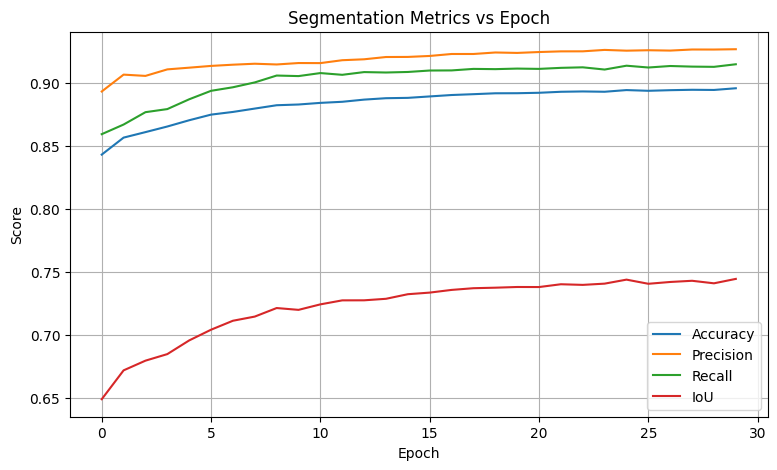

In [10]:
# -------------------------
# SEGMENTATION METRICS vs EPOCH
# -------------------------
plt.figure(figsize=(9,5))

plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["precision"], label="Precision")
plt.plot(history.history["recall"], label="Recall")
plt.plot(history.history["iou"], label="IoU")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Segmentation Metrics vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


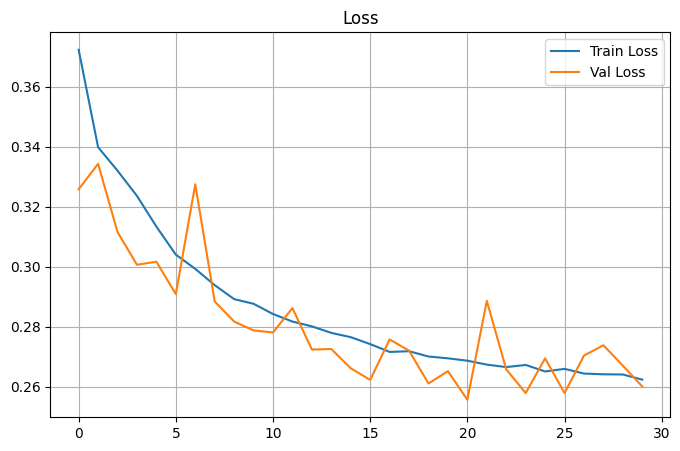

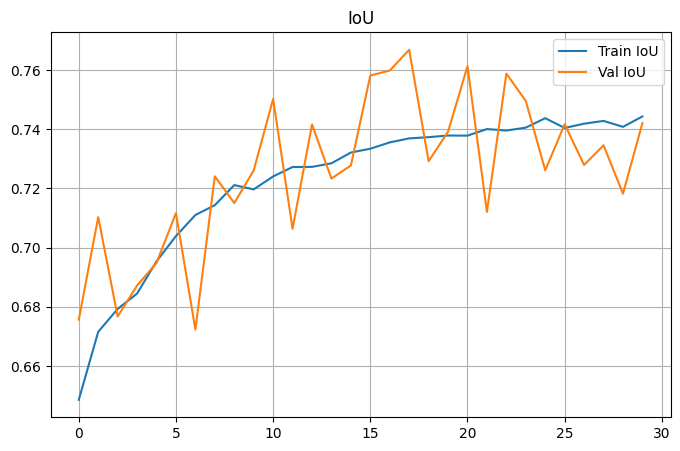

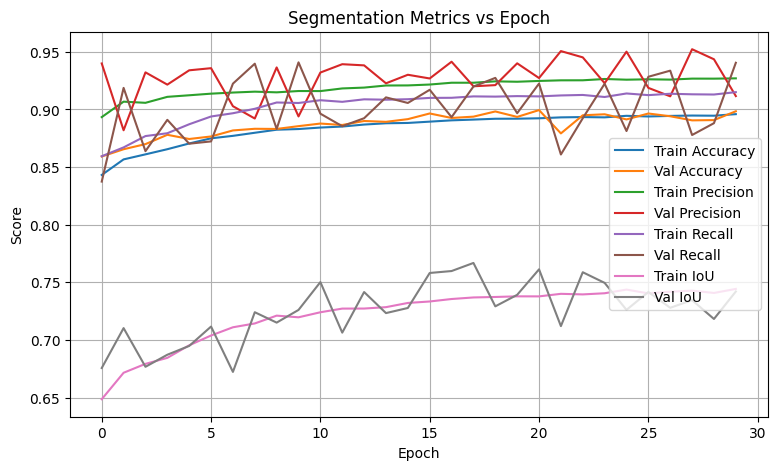

587/587 [==============================] - 62s 105ms/step - loss: 0.2601 - accuracy: 0.8984 - precision: 0.9116 - recall: 0.9405 - iou: 0.7421
[0.26012900471687317, 0.8984009027481079, 0.9115747809410095, 0.9404613971710205, 0.7420551776885986]


C:\Users\matin\miniconda3\envs\tf310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model: keras_unet_cloud_30epochfix_128img.h5


In [11]:
# -------------------------
# PLOT CURVES
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train Loss","Val Loss"])
plt.grid(True)
plt.title("Loss")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["iou"])
plt.plot(history.history["val_iou"])
plt.legend(["Train IoU","Val IoU"])
plt.grid(True)
plt.title("IoU")
plt.show()

#Extras: validation metrics plot
plt.figure(figsize=(9,5))

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")

plt.plot(history.history["precision"], label="Train Precision")
plt.plot(history.history["val_precision"], label="Val Precision")

plt.plot(history.history["recall"], label="Train Recall")
plt.plot(history.history["val_recall"], label="Val Recall")

plt.plot(history.history["iou"], label="Train IoU")
plt.plot(history.history["val_iou"], label="Val IoU")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Segmentation Metrics vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


# -------------------------
# EVALUATE
# -------------------------
print(model.evaluate(val_ds))


# -------------------------
# SAVE MODEL
# -------------------------
model.save("keras_unet_cloud_30epochfix_128img.h5")
print("Saved model: keras_unet_cloud_30epochfix_128img.h5")